+++
notebook = true
date = "2023-010-13T11:00:13+01:00"
title = "Mesh Tutorial"
author = "Christoph Lehmann, Feliks Kiszkurno, Frieder Loer"
weight = 2
toc = true
+++


<div class="note">
    <p style="margin-top: 0; margin-bottom: 0;">
        <img style="margin-top: 0; margin-bottom: 0; height: 2em;" class="inline-block mr-2 no-fancybox"
            src="https://upload.wikimedia.org/wikipedia/commons/3/38/Jupyter_logo.svg" alt="">
        This page is based on a Jupyter notebook.
<a href="./mesh_tutorial.ipynb" download="mesh_tutorial.ipynb"><img class="no-fancybox" style="display: inline; margin-top: 0; margin-bottom: 0; margin-left: 1em;" src="https://img.shields.io/static/v1?label=Download:&message=mesh_tutorial.ipynb&color=blue" /></a>
<a href="https://gitlab.opengeosys.org/ogs/ogs/-/blob/master/Tests/Data/../../web/content/docs/tutorials/mesh_tutorial/notebook-mesh_tutorial.md"><img src="https://img.shields.io/static/v1?label=Source:&message=notebook-mesh_tutorial.md&color=brightgreen" class="no-fancybox"
        style="display: inline; margin-top: 0; margin-bottom: 0; margin-left: 1em;" /></a>
<a href="https://binder.opengeosys.org/v2/gh/bilke/binder-ogs-requirements/master?urlpath=git-pull%3Frepo=https://gitlab.opengeosys.org/ogs/ogs%26urlpath=lab/tree/ogs/Tests/Data/../../web/content/docs/tutorials/mesh_tutorial/notebook-mesh_tutorial.md%26branch=master%26depth=1">
    <img class="no-fancybox" style="display: inline; margin-top: 0; margin-bottom: 0; margin-left: 1em;"
        src="https://img.shields.io/static/v1?label=&message=Launch notebook&color=5c5c5c&logo=" />
</a></p></div>

## Goals

In this tutorial the user will learn to use some of the tools provided with OpenGeoSys to create simple mesh for a simulation.

## Requirements

- A running version of OpenGeoSys (it can be installed via `pip`, as a container or as 'CLI with utilities' binary download)
- It is assumed, that regardless of how OGS is installed, it is added to the environment variables and is accessible from the shell.
- In case of a problem, please consult the [installation]({{< ref "/docs/userguide/basics/introduction" >}}) and [troubleshooting]({{< ref "/docs/userguide/troubleshooting/get-support" >}}) pages.
- For viewing a mesh with PyVista, Python is required.
- To run the Jupyter notebook that accompanies this tutorial, a Python environment with Jupyter, PyVista, NumPy and Matplotlib packages is needed.

Please note that this tutorial doesn't cover Python. The user is expected to have basic understanding of it. Alternatively, other tools capable of reading mesh files can be used (for example: [ParaView](https://www.paraview.org/)).

A basic understanding of meshes would make following this tutorial easier but is not required.

## Conventions

If parameters can take different values (for example to apply them in different directions) variable part of command will be indicated by `$` sign followed by name.

For example directional parameters set `-dx -dy -dz` will be indicated by `-d$direction $value`.  
This doesn't apply to code snippets, there the parameters will be written explicitly.

`!` is used to run shell commands from within the Jupyter notebook.

## Useful links  

It is not mandatory to read the following articles before starting with the tutorial, but they can provide some expansion and additional explanation to the content presented here.

- [OpenGeoSys tools documentation]({{< ref "/docs/tools/getting-started/overview" >}})
- [Structured mesh generation]({{< ref "structured-mesh-generation" >}})
- [Extracting surfaces]({{< ref "extract-surface" >}})
- [Removing mesh elements]({{< ref "remove-mesh-elements" >}})
- [PyVista documentation (external link)](https://docs.pyvista.org/)

## Overview over the tutorial

In this tutorial, some tools that can be used to create a mesh will be presented with a short description and an example.
These tools are shipped as executables with OGS:

- [generateStructuredMesh]({{< ref "structured-mesh-generation" >}})
- [ExtractBoundary]({{< ref "extract-boundary" >}})
- [removeMeshElements]({{< ref "remove-mesh-elements" >}})

Afterwards, you can test your understanding with a couple of exercises.  

## Preparations

We first set an output directory and import some required libraries. This tutorial uses PyVista for visualization of the meshes.

In [1]:
import os
from pathlib import Path

# All generated files will be put there
out_dir = Path(os.environ.get("OGS_TESTRUNNER_OUT_DIR", "_out"))
if not out_dir.exists():
    out_dir.mkdir(parents=True)

In [2]:
# Use pyvista for visualization of the generated meshes
import pyvista as pv
pv.set_plot_theme("document")
pv.set_jupyter_backend("static")

In [3]:
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# Define some plotting functions

def show_mesh(mesh):
    plotter = pv.Plotter()
    plotter.add_mesh(mesh, show_edges=True)
    plotter.view_xy()
    plotter.add_axes()
    plotter.show_bounds(mesh, xtitle="x", ytitle="y")
    plotter.window_size = [800, 400]
    plotter.show()

def show_mesh_3D(mesh):
    plotter = pv.Plotter()
    plotter.add_mesh(mesh, show_edges=True)
    plotter.add_axes()
    plotter.window_size = [800, 400]
    plotter.show()

def show_cell_sizes_x(mesh):
    line = mesh.slice_along_line(pv.Line((0,1e-8,0),(7,1e-8,0), resolution=2))

    fig, ax = plt.subplots()

    cell_lengths_x = np.diff(line.points[:,0])
    num_cells_x = len(cell_lengths_x)
    cell_idcs_x = np.arange(1, num_cells_x+1)

    ax.plot(cell_idcs_x, cell_lengths_x, marker=".", label="cell sizes from mesh")
    ax.plot(cell_idcs_x, 1.2**cell_idcs_x * 0.5, label="cell sizes expected, up to a factor")

    ax.legend()
    ax.set_xtitle("cell id in $x$ direction")
    ax.set_ytitle("cell size in $x$ direction")

    ax.set_yscale("log")

## Structured mesh generation

You can start by checking the version of the generateStructuredMesh tool, it will test whether your OpenGeoSys is correctly installed and available:

In [5]:
! generateStructuredMesh --version
assert _exit_code == 0


generateStructuredMesh  version: 6.5.4-350-g59610e9832



This command should deliver the following output:  

```bash
generateStructuredMesh  version: - some version -
```


You can view basic documentation using this command:

In [6]:
! generateStructuredMesh --help
assert _exit_code == 0


USAGE: 

   generateStructuredMesh  [-h] [--version] [--dx-max <real>] [--dx0
                           <real>] [--dy-max <real>] [--dy0 <real>]
                           [--dz-max <real>] [--dz0 <real>] [--lx <real>]
                           [--ly <real>] [--lz <real>] [--mx <real>] [--my
                           <real>] [--mz <real>] [--nx <integer>] [--ny
                           <integer>] [--nz <integer>] [--ox <real>] [--oy
                           <real>] [--oz <real>] -e <line|tri|quad|hex|
                           prism|tet|pyramid> -o <file name of output mesh>


Where: 

   -e <line|tri|quad|hex|prism|tet|pyramid>,  --element-type <line|tri|quad|
      hex|prism|tet|pyramid>
     (required) element type to be created: line | tri | quad | hex | prism
     | tet | pyramid

   -o <file name of output mesh>,  --mesh-output-file <file name of output
      mesh>
     (required) the name of the file the mesh will be written to

   --lx <real>
     length of a domain in

### Quadrilateral mesh

In this step a simple rectangular mesh of size 3 by 4 units, with 4 and 5 cells respectively will be created and written to a `quad.vtu` file in folder `output`.  
Please follow the folder and file names provided in each step, as some files will be reused later.  

In order to select the type of the elements, that the mesh is built with you use the flag `-e` followed by one of the available mesh element types.  
In this section a mesh of quadrilateral elements is created, so the command will be as follows:

```bash
generateStructuredMesh -e quad
```

this however, is not a complete command.  
There are more required parameters, next the name of the output file has to be provided.  
It is done using the flag `-o` followed by a file name.  
If the mesh file should be written to a folder, it can be provided as path relative to the place from where the command is run.  
For example:

```bash
generateStructuredMesh -e quad -o folder1/folder2/mesh_file_name.vtu
```  

There are two more groups of parameters that need to be provided: length of the mesh in each direction and number of cells in each direction.  
The length parameters are indicated by `--l$direction $length`, where `$direction` is the direction indicated by x, y or z and `$length` is length of the mesh.  
In order to create mesh with length of 3 in x-direction and 4 in y-direction.  
The number of cells is provided in the same convention with parameter `--n`: `--n$direction $length`.  
In order to create 4 cells in x-direction and 5 cells in y-direction.  
The complete command can be written as follows:

```bash
generateStructuredMesh -e quad -o {out_dir}/quads.vtu --lx 3 --ly 4 --nx 4 --ny 5
```  

The created mesh can be viewed with any software supporting `.vtu`-file format and should look as in the following figure.

Let's create the mesh with the above command and visualize it:


[2025-04-11 09:32:29.319] [ogs] [info] Mesh created: 30 nodes, 20 elements.


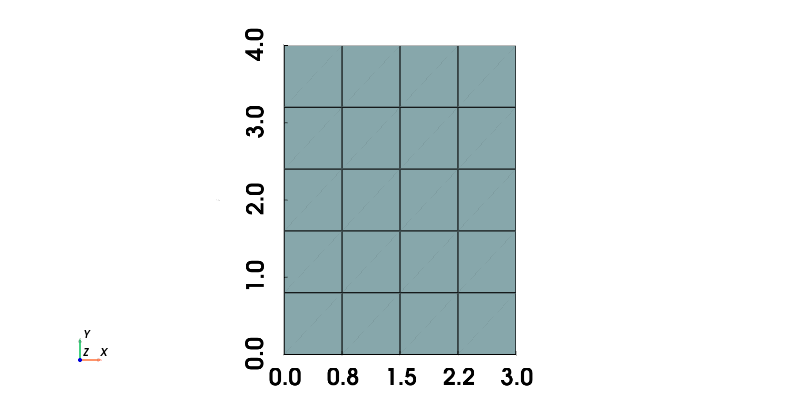

In [7]:
! generateStructuredMesh -e quad -o {out_dir}/quad.vtu --lx 3 --ly 4 --nx 4 --ny 5
assert _exit_code == 0
mesh = pv.read(f"{out_dir}/quad.vtu")
show_mesh(mesh)


### Triangle mesh

In this step a mesh using triangular cells will be created.  
The size and number of cells will remain the same as in previous example.  
The produced mesh file will be placed in `output` folder in `triangle.vtu` file.  

Compared to the command from previous step, only element type and output file name changes, therefore we can use it:

```bash
generateStructuredMesh -e quad -o out/quads.vtu --lx 3 --ly 4 --nx 4 --ny 5
```  

after changing element type `quad` to `tri` and file name `quad.vtu` to `triangle.vtu`:


In [8]:
! generateStructuredMesh -e tri -o {out_dir}/triangle.vtu --lx 3 --ly 4 --nx 4 --ny 5
assert _exit_code == 0

[2025-04-11 09:32:29.842] [ogs] [info] Mesh created: 30 nodes, 40 elements.


Running this command should create following mesh:

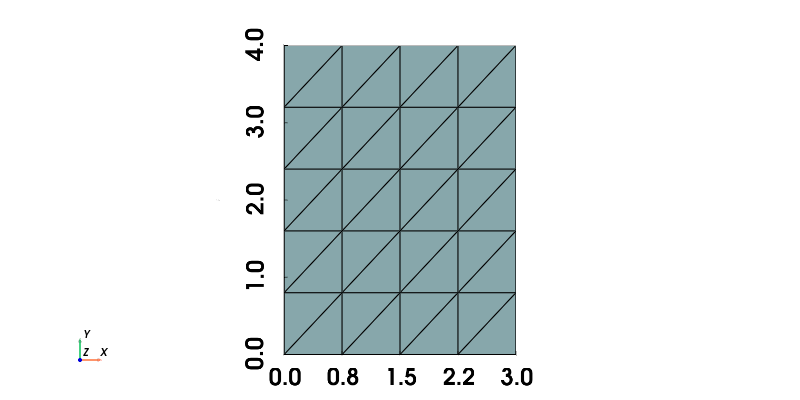

In [9]:
mesh = pv.read(f"{out_dir}/triangle.vtu")
show_mesh(mesh)

### Shifting the reference point of the mesh

By adding parameter `--o$direction $value`, the reference point of the created mesh can be shifted.  

In this example, the mesh from the step [Quadrilateral mesh](#quadrilateral-mesh), will be created again but with the reference point shifted from (0,0) to (2,5) (in (x,y) format).  

In order to do this, the final command from that step will be expanded by `--ox 2 --oy 5`:

In [10]:
! generateStructuredMesh -e quad -o {out_dir}/quads.vtu --lx 3 --ly 4 --nx 4 --ny 5 --ox 2 --oy 5
assert _exit_code == 0

[2025-04-11 09:32:30.348] [ogs] [info] Mesh created: 30 nodes, 20 elements.


Running this command should create following mesh:

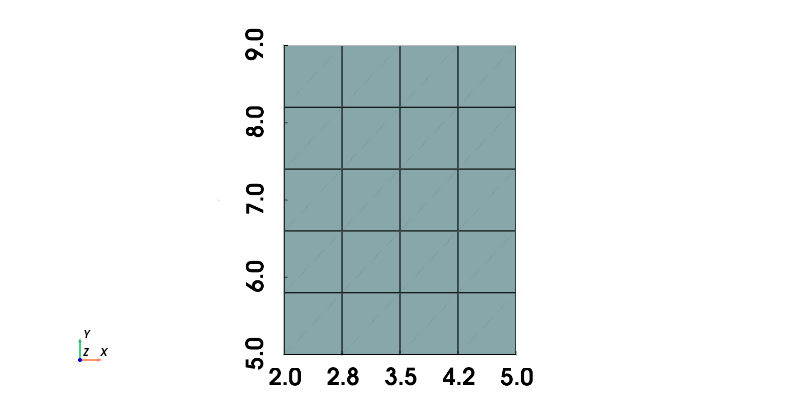

In [11]:
mesh = pv.read(f"{out_dir}/quads.vtu")
show_mesh(mesh)

Compare the values on X and Y axis with the ones in the figure in step [Quadrilateral mesh](#quadrilateral-mesh).

### Quadrilateral graded meshes

#### ...with automatically computed cell sizes  

In this step a quadrilateral mesh with size of 7 in x-direction and 4 in y-direction (10 and 5 cells respectively) will be created.  
However, this time an additional parameter will be passed.  
It will change the sizes of the cells from equal to increasingly progressing.

By adding `--mx 1.2`, each next cell (in positive direction alongside x-axis) will be 1.2 times bigger than the previous one.  
Value below zero will make cells smaller than the previous ones.

The command to create this mesh:

In [12]:
! generateStructuredMesh -e quad -o {out_dir}/quads_graded.vtu --lx 7 --ly 4 --nx 10 --ny 5 \
    --mx 1.2
assert _exit_code == 0

[2025-04-11 09:32:30.812] [ogs] [info] Mesh created: 66 nodes, 50 elements.


Note that the name of the output file, values in `--l` and `--n` were changed compared to the command in [Quadrilateral mesh](#quadrilateral-mesh) step.  
The `\` allows to break the line and split command into more than one line to improve its readability.  
Running it produces following mesh:

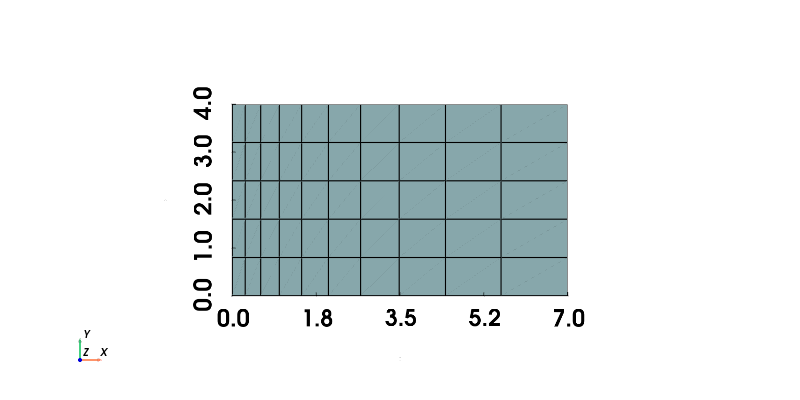

In [13]:
mesh = pv.read(f"{out_dir}/quads_graded.vtu")
show_mesh(mesh)

#### ...with automatically computed cell sizes with given initial cell size

The command from previous step can be expanded with parameter `--d$direction0 $value` to define initial cell size, alongside `$direction` (x, y, or z).  
Let's say that the initial cell size is 1.  
For this case following parameter should be appended: `--dx0 1`.  
Expanded command from previous step:

In [14]:
! generateStructuredMesh -e quad -o {out_dir}/quads_graded_init_size.vtu --lx 7 --ly 4 --ny 5 \
    --mx 1.2 --dx0 1
assert _exit_code == 0

[2025-04-11 09:32:31.242] [ogs] [info] Mesh created: 30 nodes, 20 elements.


Note, that output file name has been changed, too.  

The mesh produced by that command can be seen in this figure:

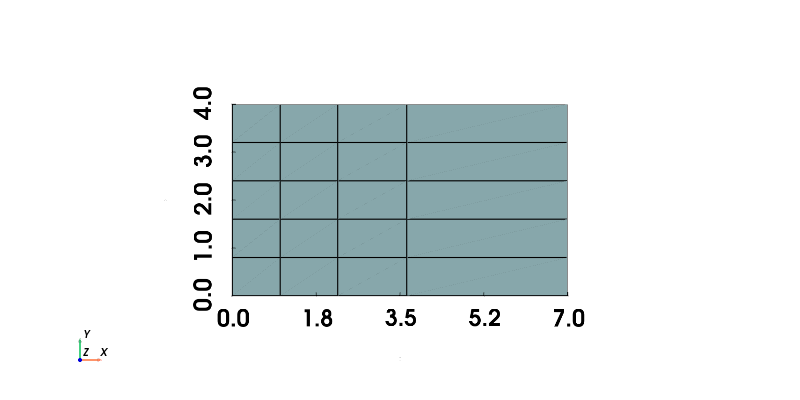

In [15]:
mesh = pv.read(f"{out_dir}/quads_graded_init_size.vtu")
show_mesh(mesh)

#### ...with automatically computed cell sizes with given initial cell size and maximum cell size

In many cases it may be useful to set a maximal cell size.
That can be achieved via the `--d$direction-max $value` parameter.

The command from the previous step can be expanded by: `--dx-max 2`:

In [16]:
! generateStructuredMesh -e quad -o {out_dir}/quads_graded_max_size.vtu --lx 7 --ly 4 --ny 5 \
    --mx 1.2 --dx0 1 --dx-max 2
assert _exit_code == 0


[2025-04-11 09:32:31.694] [ogs] [info] Mesh created: 30 nodes, 20 elements.


Note that the length of mesh and numbers of cells has been modified compared to the previous step in order to improve visibility of the effect of the maximum cell size parameter.

The mesh produced by that command can be seen in this figure:

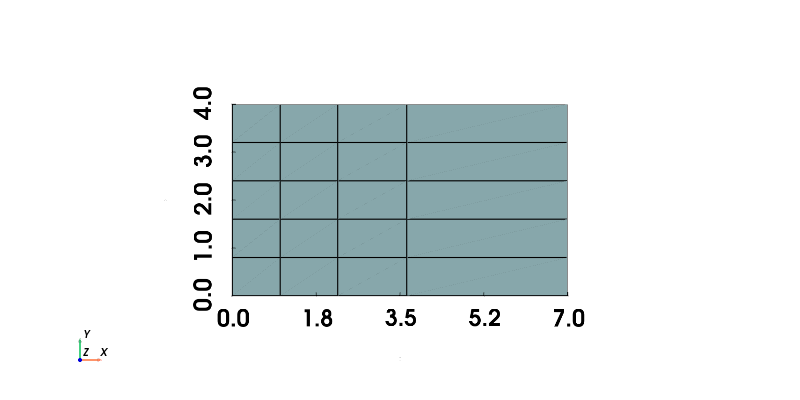

In [17]:
mesh = pv.read(f"{out_dir}/quads_graded_max_size.vtu")
show_mesh(mesh)

### Structured mesh in 3D

In previous examples only 2D meshes were created.  
`createStructuredMesh` is capable of creating 3D meshes, too.

In order to create one, the element type has to be changed to a 3D one and parameters `--lz` and `--nz` need to be passed additionally.  
In 3D, the quadrilateral element type has to be replaced by hexahedral one.

In [18]:
! generateStructuredMesh -e hex -o {out_dir}/hexes.vtu --lx 7 --ly 4 --lz 3 --nx 10 --ny 5 --nz 3
assert _exit_code == 0


[2025-04-11 09:32:32.086] [ogs] [info] Mesh created: 264 nodes, 150 elements.


The command above will create the following mesh:

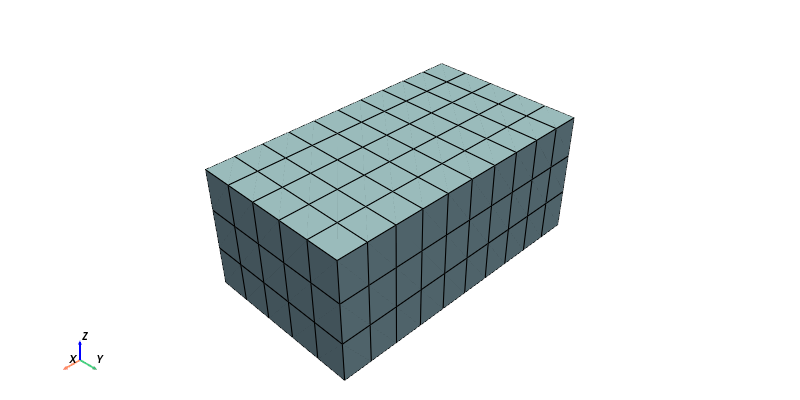

In [19]:
mesh = pv.read(f"{out_dir}/hexes.vtu")
plotter = pv.Plotter()
plotter.add_mesh(mesh, show_edges=True)
plotter.window_size = [800, 400]
plotter.add_axes()
plotter.show()

## Surface extraction

The following was mainly taken from https://www.opengeosys.org/docs/tools/meshing-submeshes/submeshes/  

For Finite Element simulations, we need to specify subdomains e.g. for boundary conditions.  
One possibility is to precompute the subdomains as meshes by extracting them from our domain.  
This way the subdomains additionally contain information to identify the corresponding bulk mesh entities like nodes, elements, and faces of elements.

We can extract subdomains using the OGS tool [`ExtractBoundary`]({{< ref "extract-boundary" >}}).
Type `! ExtractBoundary --help` for a basic documentation.

In [20]:
! ExtractBoundary --help
assert _exit_code == 0


USAGE: 

   ExtractBoundary  [-h] [--ascii-output] [--version] [-o <file name of
                    output mesh>] -i <file name of input mesh>


Where: 

   -i <file name of input mesh>,  --mesh-input-file <file name of input
      mesh>
     (required) the name of the file containing the input mesh

   -o <file name of output mesh>,  --mesh-output-file <file name of output
      mesh>
     the name of the file the surface mesh should be written to

   --ascii-output
     If the switch is set use ascii instead of binary format for data in
     the vtu output.

   --,  --ignore_rest
     Ignores the rest of the labeled arguments following this flag.

   --version
     Displays version information and exits.

   -h,  --help
     Displays usage information and exits.

   Tool extracts the boundary of the given mesh. The documentation is
   available at
   https://docs.opengeosys.org/docs/tools/meshing-submeshes/extract-boundar
   y.
   
   OpenGeoSys-6 software, version 6.5.4-350-g59610

### In 2D

We start with extracting the boundary of a 2D mesh.  
Let's remind ourselves of the mesh by visualizing it once more.

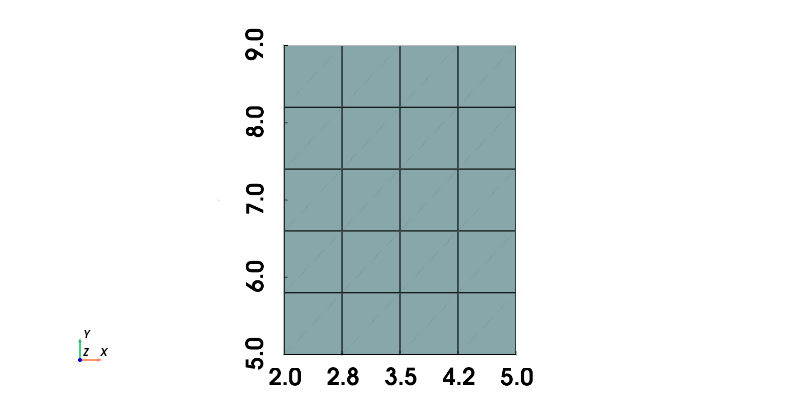

In [21]:
mesh = pv.read(f"{out_dir}/quads.vtu")
show_mesh(mesh)

From above we can see the required arguments for using the `ExtractBoundary` tool.  
We pass in the mesh to extract the boundary from `quads.vtu` and save the boundary to `quads_boundary.vtu`.

In [22]:
! ExtractBoundary -i "{out_dir}/quads.vtu" -o "{out_dir}/quads_boundary.vtu"
assert _exit_code == 0

[2025-04-11 09:32:32.994] [ogs] [info] Mesh read: 30 nodes, 20 elements.
[2025-04-11 09:32:32.994] [ogs] [info] 0 property vectors copied, 0 vectors skipped.
[2025-04-11 09:32:32.994] [ogs] [info] Created surface mesh: 18 nodes, 18 elements.


Visualize the output mesh:

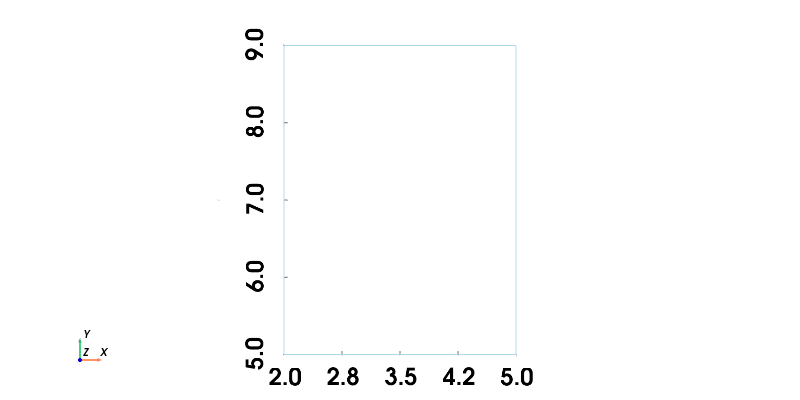

In [23]:
boundary_mesh = pv.read(f"{out_dir}/quads_boundary.vtu")
show_mesh(boundary_mesh)

As shown above, the boundary of a 2D mesh is just a set of lines.

### In 3D

We can use the same command to extract the boundary of a 3D mesh.

In [24]:
# Using a previously generated mesh
! ExtractBoundary -i "{out_dir}/hexes.vtu" -o "{out_dir}/hexes_boundary.vtu"
assert _exit_code == 0

[2025-04-11 09:32:33.396] [ogs] [info] Mesh read: 264 nodes, 150 elements.
[2025-04-11 09:32:33.396] [ogs] [info] 0 property vectors copied, 0 vectors skipped.
[2025-04-11 09:32:33.396] [ogs] [info] Created surface mesh: 192 nodes, 190 elements.


And visualize it:

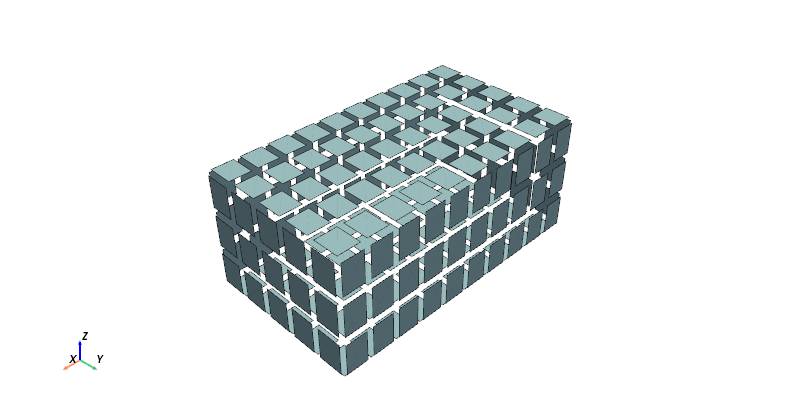

In [25]:
boundary_mesh = pv.read(f"{out_dir}/hexes_boundary.vtu")
show_mesh_3D(boundary_mesh.shrink(0.8))

## Mesh clipping

The tool `removeMeshElements` removes those elements from a given input mesh that fulfill a user specified criterion.  
The resulting mesh will be written to the specified output file.  
Type `! removeMeshElements --help` for a basic documentation.

In [26]:
! removeMeshElements --help
assert _exit_code == 0


USAGE: 

   removeMeshElements  [-hz] [--inside] [--invert] [--outside] [--version]
                       [-n <string>] [-t <point|line|tri|quad|hex|prism|tet|
                       pyramid> ...] [--max-value <number>] [--min-value
                       <number>] [--property-value <number> ...] [--x-max
                       <value>] [--x-min <value>] [--y-max <value>]
                       [--y-min <value>] [--z-max <value>] [--z-min
                       <value>] -i <file name of input mesh> -o <file name
                       of output mesh>


Where: 

   --invert
     inverts the specified bounding box

   --z-max <value>
     largest allowed extent in z-dimension

   --z-min <value>
     smallest allowed extent in z-dimension

   --y-max <value>
     largest allowed extent in y-dimension

   --y-min <value>
     smallest allowed extent in y-dimension

   --x-max <value>
     largest allowed extent in x-dimension

   --x-min <value>
     smallest allowed extent in x-dimensi

The user can choose between 4 different removal criteria:

1. Remove elements by assigned properties, for instance material ids.  
2. Remove elements by element type, for instance remove line elements.  
3. Remove elements that have zero volume.  
4. Remove elements by axis aligned bounding box criterion.  

Let's load the boundary mesh that we have extracted in the last step:

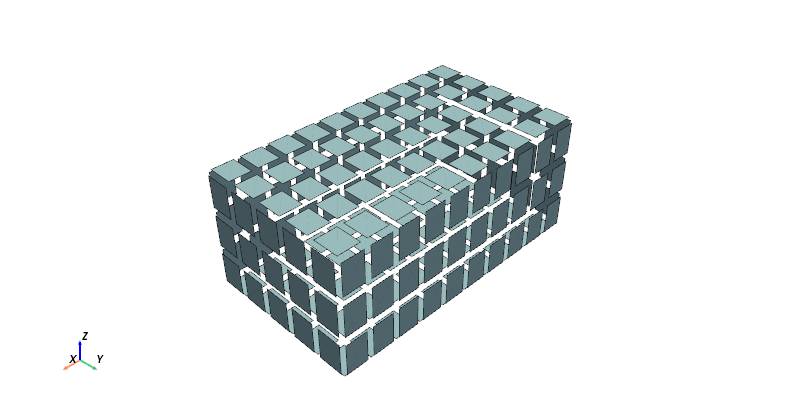

(0.0, 7.0, 0.0, 4.0, 0.0, 3.0)

In [27]:
boundary_mesh = pv.read(f"{out_dir}/hexes_boundary.vtu")
show_mesh_3D(boundary_mesh.shrink(0.8))

xmin, xmax, ymin, ymax, zmin, zmax = boundary_mesh.bounds
boundary_mesh.bounds

We remove all mesh elements except for the ones at the minimum z-value i.e. the plane at the minimum z-value.

[2025-04-11 09:32:34.125] [ogs] [info] Mesh read: 192 nodes, 190 elements.
[2025-04-11 09:32:34.125] [ogs] [info] Bounding box of "hexes_boundary" is
x = [0.000000,7.000000]
y = [0.000000,4.000000]
z = [0.000000,3.000000]
[2025-04-11 09:32:34.125] [ogs] [info] 140 elements found.
[2025-04-11 09:32:34.125] [ogs] [info] Removing total 140 elements...
[2025-04-11 09:32:34.125] [ogs] [info] 50 elements remain in mesh.
[2025-04-11 09:32:34.125] [ogs] [info] Removing total 126 nodes...


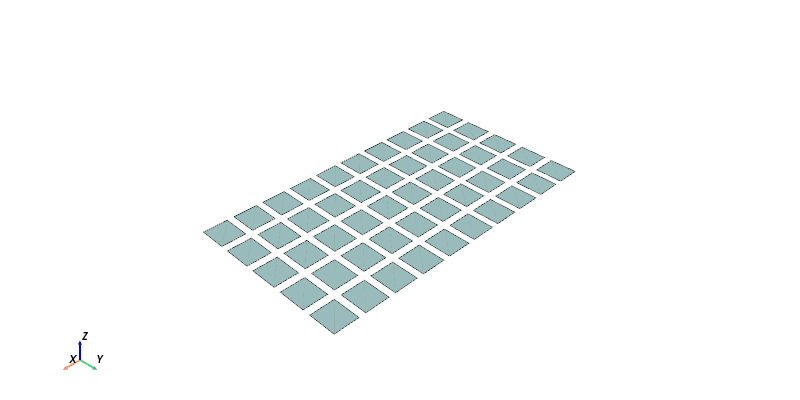

In [28]:
! removeMeshElements -i "{out_dir}/hexes_boundary.vtu" -o "{out_dir}/hexes_zmin.vtu" --z-min {zmin + 1e-8}
assert _exit_code == 0
mesh = pv.read(f"{out_dir}/hexes_zmin.vtu")
show_mesh_3D(mesh.shrink(0.8))

We can also remove all other bounding planes and plot them.

In [29]:
! removeMeshElements -i "{out_dir}/hexes_boundary.vtu" -o "{out_dir}/hexes_zmax.vtu" --z-max {zmax - 1e-8}
assert _exit_code == 0
! removeMeshElements -i "{out_dir}/hexes_boundary.vtu" -o "{out_dir}/hexes_xmin.vtu" --x-min {xmin + 1e-8}
assert _exit_code == 0
! removeMeshElements -i "{out_dir}/hexes_boundary.vtu" -o "{out_dir}/hexes_xmax.vtu" --x-max {xmax - 1e-8}
assert _exit_code == 0
! removeMeshElements -i "{out_dir}/hexes_boundary.vtu" -o "{out_dir}/hexes_ymin.vtu" --y-min {ymin + 1e-8}
assert _exit_code == 0
! removeMeshElements -i "{out_dir}/hexes_boundary.vtu" -o "{out_dir}/hexes_ymax.vtu" --y-max {ymax - 1e-8}
assert _exit_code == 0

[2025-04-11 09:32:34.542] [ogs] [info] Mesh read: 192 nodes, 190 elements.
[2025-04-11 09:32:34.542] [ogs] [info] Bounding box of "hexes_boundary" is
x = [0.000000,7.000000]
y = [0.000000,4.000000]
z = [0.000000,3.000000]
[2025-04-11 09:32:34.543] [ogs] [info] 140 elements found.
[2025-04-11 09:32:34.543] [ogs] [info] Removing total 140 elements...
[2025-04-11 09:32:34.543] [ogs] [info] 50 elements remain in mesh.
[2025-04-11 09:32:34.543] [ogs] [info] Removing total 126 nodes...


[2025-04-11 09:32:34.802] [ogs] [info] Mesh read: 192 nodes, 190 elements.
[2025-04-11 09:32:34.802] [ogs] [info] Bounding box of "hexes_boundary" is
x = [0.000000,7.000000]
y = [0.000000,4.000000]
z = [0.000000,3.000000]
[2025-04-11 09:32:34.802] [ogs] [info] 175 elements found.
[2025-04-11 09:32:34.802] [ogs] [info] Removing total 175 elements...
[2025-04-11 09:32:34.802] [ogs] [info] 15 elements remain in mesh.
[2025-04-11 09:32:34.802] [ogs] [info] Removing total 168 nodes...


[2025-04-11 09:32:35.052] [ogs] [info] Mesh read: 192 nodes, 190 elements.
[2025-04-11 09:32:35.052] [ogs] [info] Bounding box of "hexes_boundary" is
x = [0.000000,7.000000]
y = [0.000000,4.000000]
z = [0.000000,3.000000]
[2025-04-11 09:32:35.052] [ogs] [info] 175 elements found.
[2025-04-11 09:32:35.052] [ogs] [info] Removing total 175 elements...
[2025-04-11 09:32:35.052] [ogs] [info] 15 elements remain in mesh.
[2025-04-11 09:32:35.052] [ogs] [info] Removing total 168 nodes...


[2025-04-11 09:32:35.299] [ogs] [info] Mesh read: 192 nodes, 190 elements.
[2025-04-11 09:32:35.299] [ogs] [info] Bounding box of "hexes_boundary" is
x = [0.000000,7.000000]
y = [0.000000,4.000000]
z = [0.000000,3.000000]
[2025-04-11 09:32:35.299] [ogs] [info] 160 elements found.
[2025-04-11 09:32:35.299] [ogs] [info] Removing total 160 elements...
[2025-04-11 09:32:35.299] [ogs] [info] 30 elements remain in mesh.
[2025-04-11 09:32:35.299] [ogs] [info] Removing total 148 nodes...


[2025-04-11 09:32:35.520] [ogs] [info] Mesh read: 192 nodes, 190 elements.
[2025-04-11 09:32:35.520] [ogs] [info] Bounding box of "hexes_boundary" is
x = [0.000000,7.000000]
y = [0.000000,4.000000]
z = [0.000000,3.000000]
[2025-04-11 09:32:35.520] [ogs] [info] 160 elements found.
[2025-04-11 09:32:35.520] [ogs] [info] Removing total 160 elements...
[2025-04-11 09:32:35.520] [ogs] [info] 30 elements remain in mesh.
[2025-04-11 09:32:35.520] [ogs] [info] Removing total 148 nodes...


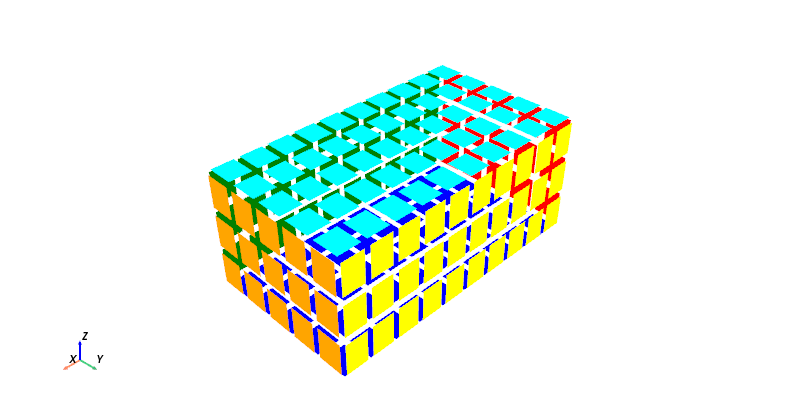

In [30]:
plotter = pv.Plotter()
plotter.add_mesh(pv.read(f"{out_dir}/hexes_xmin.vtu").shrink(0.8), lighting=False, color="red")
plotter.add_mesh(pv.read(f"{out_dir}/hexes_xmax.vtu").shrink(0.8), lighting=False, color="orange")
plotter.add_mesh(pv.read(f"{out_dir}/hexes_ymin.vtu").shrink(0.8), lighting=False, color="green")
plotter.add_mesh(pv.read(f"{out_dir}/hexes_ymax.vtu").shrink(0.8), lighting=False, color="yellow")
plotter.add_mesh(pv.read(f"{out_dir}/hexes_zmin.vtu").shrink(0.8), lighting=False, color="blue")
plotter.add_mesh(pv.read(f"{out_dir}/hexes_zmax.vtu").shrink(0.8), lighting=False, color="cyan")
plotter.add_axes()
plotter.window_size = [800,400]
plotter.show()

## The special case: generating 0D boundary and source term meshes for OGS

At the moment (Sep 2024) the [`ExtractBoundary`]({{< ref "extract-boundary" >}})
tool unfortunately does not support extracting the zero dimensional boundary of
a one dimensional mesh.
To create such zero dimensional meshes suitable for source terms and boundary
conditions in OGS the following can be done, among others.

First, create a `gml` file with the following content. Change point coordinates
to your needs.

```xml
<?xml version="1.0" encoding="ISO-8859-1"?>
<?xml-stylesheet type="text/xsl" href="OpenGeoSysGLI.xsl"?>
<OpenGeoSysGLI xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xmlns:ogs="http://www.opengeosys.org">
    <name>geometry</name>
    <points>
        <point id="0" x="0.0"  y="0.0" z="0.0" name="source"/>
    </points>
</OpenGeoSysGLI>
```

Then, run [`constructMeshesFromGeometry`]({{< ref "constructmeshesfromgeometry" >}}),
which will produce a mesh consisting of the single point and set up for use with
OGS:

```sh .noeval
constructMeshesFromGeometry -m SIMULATION_DOMAIN.vtu -g THE_GML_FILE_YOU_JUST_CREATED.gml
```

## Exercises

### Exercise 1

- Create a 2D mesh consisting of triangles.
- There shall be 7 cells in x direction and 6 cells in y direction.
- The mesh shall be 3 units wide and 4 units tall.
- Its origin shall be at (5, 1).
- The result can be visualized with `show_mesh()`.

<!-- markdownlint-disable code-fence-style -->
~~~python
# Put your solution here

# Visualize your result
mesh_name = "" # Put your mesh name inside the ""
mesh = pv.read(f"out/{mesh_name}")
show_mesh(mesh)
~~~

### Exercise 2

Consider the mesh from the beginning of the previous step:  

```bash
! generateStructuredMesh -e quad -o {out_dir}/quads.vtu --lx 3 --ly 4 --nx 4 --ny 5
```  

Remove all elements from this mesh that are not at the mesh boundary.

~~~python
# Put your solution here

# Visualize your result
mesh_name = "" # Put your mesh name inside the brackets
mesh = pv.read(f"{out_dir}/{mesh_name}")
show_mesh(mesh)
~~~
<!-- markdownlint-enable code-fence-style -->

## Solutions to the exercises

### Exercise 1

[2025-04-11 09:32:35.905] [ogs] [info] Mesh created: 56 nodes, 84 elements.


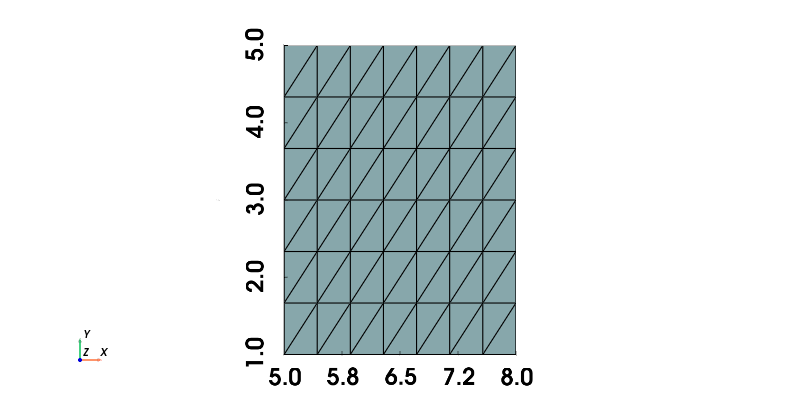

In [31]:
! generateStructuredMesh -e tri -o {out_dir}/ex1_triangle.vtu --lx 3 --ly 4 --nx 7 --ny 6 --ox 5 --oy 1
assert _exit_code == 0

# Visualize the result
mesh_name = "ex1_triangle.vtu" # Put your mesh name inside the brackets
mesh = pv.read(f"{out_dir}/{mesh_name}")
show_mesh(mesh)

### Exercise 2

[2025-04-11 09:32:36.343] [ogs] [info] Mesh read: 30 nodes, 20 elements.
[2025-04-11 09:32:36.343] [ogs] [info] 0 property vectors copied, 0 vectors skipped.
[2025-04-11 09:32:36.343] [ogs] [info] Created surface mesh: 18 nodes, 18 elements.


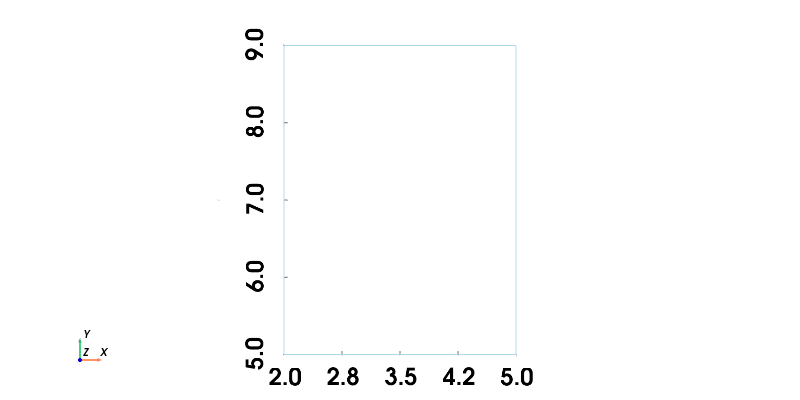

In [32]:
# Extract boundary
! ExtractBoundary -i "{out_dir}/quads.vtu" -o "{out_dir}/ex2quads_boundary.vtu"
assert _exit_code == 0

# Visualize result
mesh_name = "ex2quads_boundary.vtu" # Put your mesh name inside the brackets
mesh = pv.read(f"{out_dir}/{mesh_name}")
show_mesh(mesh)

## Which data do the created meshes contain?

### Bulk mesh

In [33]:
import pyvista as pv

# Created with: ! generateStructuredMesh -e hex -o out/hexes.vtu --lx 7 --ly 4 --lz 3 --nx 10 --ny 5 --nz 3
mesh = pv.read(f"{out_dir}/hexes.vtu")
mesh

UnstructuredGrid (0x7e198386c280)
  N Cells:    150
  N Points:   264
  X Bounds:   0.000e+00, 7.000e+00
  Y Bounds:   0.000e+00, 4.000e+00
  Z Bounds:   0.000e+00, 3.000e+00
  N Arrays:   0

From the above cell's output we see that 'N Arrays == 0'. This means there is no data contained.

### Boundary mesh

In [34]:
mesh = pv.read(f"{out_dir}/hexes_boundary.vtu") # Created by ExtractBoundary tool
mesh

UnstructuredGrid (0x7e198386c1c0)
  N Cells:    190
  N Points:   192
  X Bounds:   0.000e+00, 7.000e+00
  Y Bounds:   0.000e+00, 4.000e+00
  Z Bounds:   0.000e+00, 3.000e+00
  N Arrays:   3

In [35]:
mesh = pv.read(f"{out_dir}/hexes_xmax.vtu") # Created by ExtractBoundary tool and processed by removeMeshElements
mesh

UnstructuredGrid (0x7e1983857ee0)
  N Cells:    15
  N Points:   24
  X Bounds:   7.000e+00, 7.000e+00
  Y Bounds:   0.000e+00, 4.000e+00
  Z Bounds:   0.000e+00, 3.000e+00
  N Arrays:   3

What is this data used for?

- `bulk_node_ids` identify where the contributions of BCs and STs will go in the global equation system
- `bulk_element_ids`, `bulk_face_ids` used with some advanced features, e.g. special BCs and surface flux computation

OGS will complain if the needed data is missing for BC or ST meshes.

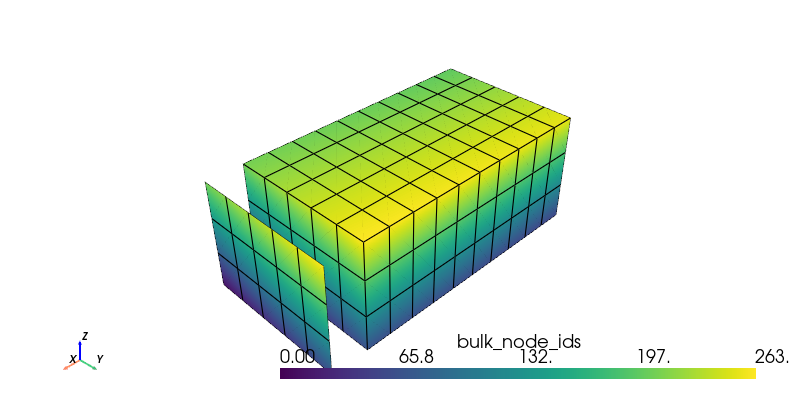

In [36]:
bulk_mesh = pv.read(f"{out_dir}/hexes.vtu")
bulk_mesh.point_data["bulk_node_ids"] = np.arange(bulk_mesh.n_points)

boundary_mesh = pv.read(f"{out_dir}/hexes_xmax.vtu")

# move the mesh a bit for better visualization
boundary_mesh.points[:,0] += 1

plotter = pv.Plotter()
plotter.add_mesh(bulk_mesh, scalars="bulk_node_ids", show_edges=True, lighting=False)
plotter.add_mesh(boundary_mesh, scalars="bulk_node_ids", show_edges=True, lighting=False)
plotter.window_size = [800,400]
plotter.add_axes()
plotter.show()

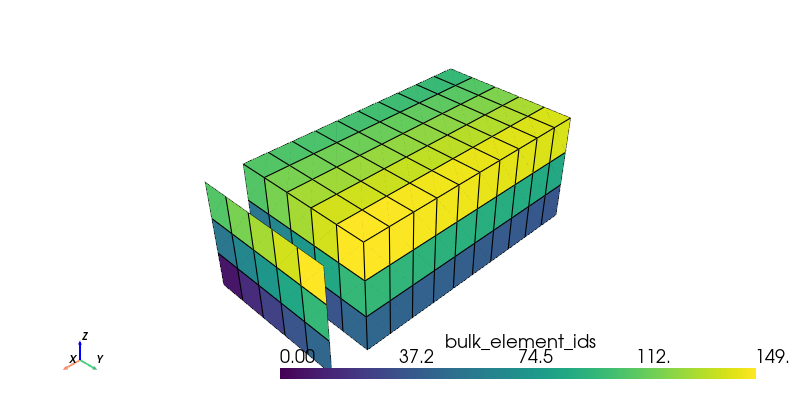

In [37]:
bulk_mesh = pv.read(f"{out_dir}/hexes.vtu")
bulk_mesh.cell_data["bulk_element_ids"] = np.arange(bulk_mesh.n_cells)

boundary_mesh = pv.read(f"{out_dir}/hexes_xmax.vtu")

# Move the mesh a bit for better visualization
boundary_mesh.points[:,0] += 1

plotter = pv.Plotter()
plotter.add_mesh(bulk_mesh, scalars="bulk_element_ids", show_edges=True, lighting=False)
plotter.add_mesh(boundary_mesh, scalars="bulk_element_ids", show_edges=True, lighting=False)
plotter.window_size = [800,400]
plotter.add_axes()
plotter.show()